Class Distribution in Training Data:
agriculture: 9874
artisinal_mine: 269
bare_ground: 687
blooming: 268
blow_down: 73
clear: 22703
cloudy: 1694
conventional_mine: 78
cultivation: 3613
habitation: 2917
haze: 2164
partly_cloudy: 5821
primary: 30006
road: 6503
selective_logging: 279
slash_burn: 162
water: 5952
New Training Dataset Size After Oversampling 'Conventional Mining': 35383
Class Distribution After Oversampling 'Conventional Mining':
agriculture: 10535
artisinal_mine: 378
bare_ground: 1002
blooming: 268
blow_down: 73
clear: 24668
cloudy: 1694
conventional_mine: 3078
cultivation: 3767
habitation: 3992
haze: 2203
partly_cloudy: 6817
primary: 32856
road: 8298
selective_logging: 279
slash_burn: 162
water: 6743
Epoch 1/10
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 1125s 471ms/step - auc: 0.7806 - binary_accuracy: 0.7808 - loss: 0.4856 - val_auc: 0.9694 - val_binary_accuracy: 0.9457 - val_loss: 0.1500
Epoch 2/10
2212/2212 ━━━━━━━━━━━━━━━━━━━━ 95s 42ms/step - auc: 0.9447 - binary_accuracy: 0.9228

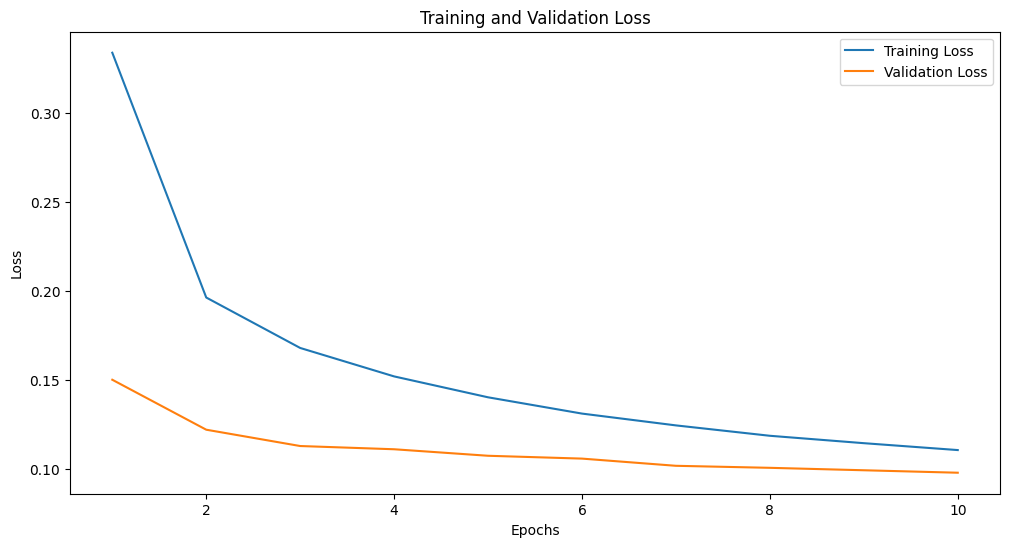

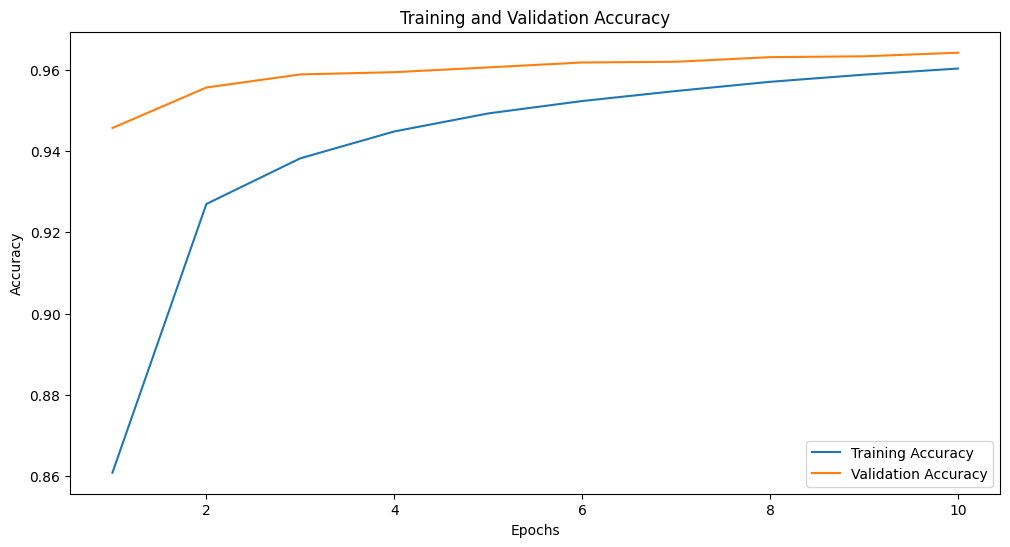

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


NameError: name 'clas' is not defined

In [ ]:
#imports
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from itertools import chain
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.metrics import AUC
from tensorflow.keras.models import Model
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

#paths
train_jpeg_dir = '/content/drive/MyDrive/satellite_imagery/train-jpg/train-jpg'
train_csv_file = '/content/drive/MyDrive/satellite_imagery/train_v2.csv'
img_resize = (128, 128)
validation_split = 0.2
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# labels
labels_df = pd.read_csv(train_csv_file)

#labels for class names
labels = sorted(set(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values])))
labels_map = {label: idx for idx, label in enumerate(labels)}  # Map labels to indices
num_classes = len(labels_map)

# turn the labels into one-hot vectors
def encode_tags(tags_str):
    tags = tags_str.split(' ')
    targets = np.zeros(num_classes, dtype='float32')
    for tag in tags:
        targets[labels_map[tag]] = 1.0
    return targets

labels_df['targets'] = labels_df['tags'].apply(encode_tags)

# split into train test validation
train_df, val_df = train_test_split(labels_df, test_size=validation_split, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Load/ preprocess images
def _load_image(path_str):
    try:
        path_str = path_str.decode('utf-8')
        with Image.open(path_str) as img:
            img = img.convert('RGB')  # 3 color channels
            img = img.resize(img_resize)
            img_array = np.array(img).astype(np.float32) / 255.0
            return (img_array * 2.0) - 1.0  # Normalize input pixel shades to [-1, 1]
    except Exception as e:
        print(f"Error loading image {path_str}: {e}")
        return np.zeros([img_resize[0], img_resize[1], 3], dtype=np.float32)

#resize images
def load_and_preprocess_image_numpy(path, label):
    image = tf.numpy_function(func=_load_image, inp=[path], Tout=tf.float32)
    image.set_shape([img_resize[0], img_resize[1], 3])  # 3 color channels
    return image, label

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def augment_image(image, label):
    return data_augmentation(image), label

# Create dataset function
def create_dataset_numpy(df, image_dir, training=True):
    image_paths = df['image_name'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg")).tolist()
    labels = np.stack(df['targets'].values)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess_image_numpy, num_parallel_calls=AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1000).map(augment_image, num_parallel_calls=AUTOTUNE)
    return dataset.batch(batch_size).prefetch(AUTOTUNE)

# Analyze class distribution
class_counts = np.sum(np.stack(train_df['targets'].values), axis=0)  # Sum along columns for one-hot encoded targets
class_counts_dict = {label: count for label, count in zip(labels_map.keys(), class_counts)}

# show class distribution
print("Class Distribution in Training Data:")
for label, count in class_counts_dict.items():
    print(f"{label}: {int(count)}")

# Oversample "conventional_mine" class
target_label = "conventional_mine"
oversampling_target_count = int(class_counts.max() / 10)  # Oversample to 1/10th of the largest class count

conventional_mine_indices = train_df[train_df['targets'].apply(lambda x: x[labels_map[target_label]] == 1)].index
conventional_mine_samples = train_df.iloc[conventional_mine_indices]

# Oversample to target count
oversampled_conventional_mine_samples = resample(
    conventional_mine_samples,
    replace=True,
    n_samples=oversampling_target_count,
    random_state=42
)

# Combine original dataset w/ oversampled "conventional_mine" samples
oversampled_train_df = pd.concat(
    [train_df, oversampled_conventional_mine_samples]
).sample(frac=1, random_state=42).reset_index(drop=True)

# new dataset size
print("New Training Dataset Size After Oversampling 'Conventional Mining':", len(oversampled_train_df))

# new class distribution
new_class_counts = np.zeros(num_classes, dtype=int)
for targets in oversampled_train_df['targets']:
    new_class_counts += np.array(targets, dtype=int)

print("Class Distribution After Oversampling 'Conventional Mining':")
for label, count in zip(labels_map.keys(), new_class_counts):
    print(f"{label}: {count}")

# oversampled training dataset
train_dataset_numpy_balanced = create_dataset_numpy(oversampled_train_df, train_jpeg_dir, training=True)

# validation dataset
val_dataset_numpy = create_dataset_numpy(val_df, train_jpeg_dir, training=False)

# model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), AUC()]
)

# Train model
history_balanced = model.fit(
    train_dataset_numpy_balanced,
    validation_data=val_dataset_numpy,
    epochs=10,
    verbose=1
)

# metrics
history_dict = history_balanced.history
epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, history_dict['loss'], label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, history_dict['binary_accuracy'], label='Training Accuracy')
plt.plot(epochs, history_dict['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Class-wise accuracies
def calculate_class_accuracies(predictions, true_labels, labels_map):
    accuracies = {}
    for class_name, class_idx in labels_map.items():
        true_positive = np.sum((predictions[:, class_idx] == 1) & (true_labels[:, class_idx] == 1))
        total_positive = np.sum(true_labels[:, class_idx])
        accuracies[class_name] = true_positive / total_positive if total_positive > 0 else 0.0
    return accuracies

for val_images, val_labels in val_dataset_numpy.take(1):
    val_predictions = model.predict(val_images)
    val_binary_predictions = (val_predictions > 0.5).astype(int)
    class_accuracies = calculate_class_accuracies(val_binary_predictions, val_labels.numpy(), labels_map)

print("Class Accuracies:", class_accuracies)

In [1]:
from sklearn.metrics import precision_recall_fscore_support

# Find class-wise metrics
def calculate_class_metrics(predictions, true_labels, labels_map):
    """
    Calculate precision, recall, F1-score, and accuracy for each class.
    """
    metrics = {}
    for class_name, class_idx in labels_map.items():
        true_positive = np.sum((predictions[:, class_idx] == 1) & (true_labels[:, class_idx] == 1))
        false_positive = np.sum((predictions[:, class_idx] == 1) & (true_labels[:, class_idx] == 0))
        false_negative = np.sum((predictions[:, class_idx] == 0) & (true_labels[:, class_idx] == 1))
        total_positive = np.sum(true_labels[:, class_idx])

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
        recall = true_positive / total_positive if total_positive > 0 else 0.0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        accuracy = true_positive / total_positive if total_positive > 0 else 0.0

        metrics[class_name] = {
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Accuracy": accuracy
        }
    return metrics

# Calculate on the validation dataset
for val_images, val_labels in val_dataset_numpy.take(1):
    val_predictions = model.predict(val_images)
    val_binary_predictions = (val_predictions > 0.5).astype(int)
    class_metrics = calculate_class_metrics(val_binary_predictions, val_labels.numpy(), labels_map)

# Metrics by class
print("Class Metrics:")
for class_name, metrics in class_metrics.items():
    print(f"{class_name}: {metrics}")

NameError: name 'val_dataset_numpy' is not defined

In [ ]:
for val_images, val_labels in val_dataset_numpy.take(1):
    val_predictions = model.predict(val_images)
    val_binary_predictions = (val_predictions > 0.5).astype(int)
    class_accuracies = calculate_class_accuracies(val_binary_predictions, val_labels.numpy(), labels_map)

print("Class Accuracies:", class_accuracies)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Class Accuracies: {'agriculture': 1.0, 'artisinal_mine': 0.0, 'bare_ground': 0.0, 'blooming': 0.0, 'blow_down': 0.0, 'clear': 0.7777777777777778, 'cloudy': 1.0, 'conventional_mine': 0.0, 'cultivation': 0.0, 'habitation': 0.3333333333333333, 'haze': 0.0, 'partly_cloudy': 1.0, 'primary': 0.9230769230769231, 'road': 0.8333333333333334, 'selective_logging': 0.0, 'slash_burn': 0.0, 'water': 0.5}
